In [4]:
# General modules
import sys
import os
import session_info
import warnings
from pyprojroot.here import here
import glob
import pandas as pd
import numpy as np
import session_info
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import pickle

# Specific modules
import scanpy as sc
import anndata as an
from matplotlib.backends.backend_pdf import PdfPages

# Setting some parameters
warnings.filterwarnings("ignore")
sys.path.insert(1, str(here('bin')))

# Import custom functions
from customPythonFunctions import generate_split_dir, composition_barplot, balanced_sample, generateID2SymbolDF


#plt.style.use(['science','nature','no-latex'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

overwriteFigures = True
overwriteData = True

**Load data**

In [5]:
adata = sc.read_h5ad(here("01_data_processing/SCGT00_CentralizedDataset/results/4_SCGT00_MAIN_HVGsubset_scVI_UMAP_clinical_allGenes.h5ad"))
adata.uns['log1p']['base'] = None # only if logscale is computed
adata

AnnData object with n_obs × n_vars = 855417 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'S_score', 'G2M_score', 'phase'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable'
    uns: '_scvi_manager_uuid', '_scvi_uuid'

In [6]:
adata.obs.head()

studyID    libraryID          sampleID  \
cellID                                                                          
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA  SCGT00  SCGT00_L051  SCGT00_I57.3P_T0   
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG  SCGT00  SCGT00_L051  SCGT00_I56.3P_T0   
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT  SCGT00  SCGT00_L051  SCGT00_I53.3P_T0   
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT  SCGT00  SCGT00_L051  SCGT00_I52.3P_T0   
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT  SCGT00  SCGT00_L051  SCGT00_I56.3P_T0   

                                       chemistry           technology  \
cellID                                                                  
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA  3_GEX_V3  3_GEX_V3_GenoHashed   
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG  3_GEX_V3  3_GEX_V3_GenoHashed   
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT  3_GEX_V3  3_GEX_V3_GenoHashed   
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT  3_GEX_V3  3_GEX_V3_GenoHashed   
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT  3_GEX_V3  3_GEX_V3_GenoHashed   

                                         patientID disease  \
cellID                                                       
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA  SCGT00_I57      RA   
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG  SCGT00_I56      RA   
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT  SCGT00_I53      RA   
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT  SCGT00_I52      RA   
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT  SCGT00_I56      RA   

                                        timepoint_replicate treatmentStatus  \
cellID                                                                        
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA                  0.0         ongoing   
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG                  0.0         ongoing   
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT                  0.0         ongoing   
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT                  0.0         ongoing   
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT                  0.0         ongoing   

                                       therapyResponse  ... pct_counts_ribo  \
cellID                                                  ...                   
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA              NR  ...       31.586402   
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG               R  ...       43.480547   
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT               R  ...       19.764252   
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT              NR  ...        3.363636   
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT               R  ...       55.809431   

                                        total_counts_hb  \
cellID                                                    
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA                0   
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG                0   
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT                3   
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT                0   
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT                0   

                                        log1p_total_counts_hb pct_counts_hb  \
cellID                                                                        
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA               0.000000      0.000000   
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG               0.000000      0.000000   
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT               1.386294      0.030485   
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT               0.000000      0.000000   
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT               0.000000      0.000000   

                                       total_counts_plt  \
cellID                                                    
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA                0   
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG                1   
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT               11   
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT                0   
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT                1   

                                  

**Loading gene marker dictionary**

In [7]:
with open(here('external_reference_data/markerGenes_dictionary.pkl'), 'rb') as f:
    marker_genes_dict = pickle.load(f)

**Plotting parameters** 

In [8]:
max_cells_plot = 200000
fraction = min(1, (max_cells_plot/adata.shape[0]))

# Clustering

First, we cluster the cells from the integrated dataset using the Leiden algorithm; this step will allow us to identify cellular structure in the dataset based on the cells' transcriptomic profile. 
In our case, we will try different low resolution parmeters to control the coarseness of the clustering, and to define the major cellular lineages, which will be further explored and clustered independently.

Following best practices: https://www.sc-best-practices.org/cellular_structure/clustering.html

Then, we can visualize and explore the different clustering results obtained at different resolutions, as well as evaluate the covariate distribution across the different clusters of interest.

In [10]:
# Resolutions of interest
resolutions_to_explore = [0.01, 0.05, 0.1]

# Co-variables of interest
list_of_variables = [ "batches", "disease", "binned_age", "sex" ]

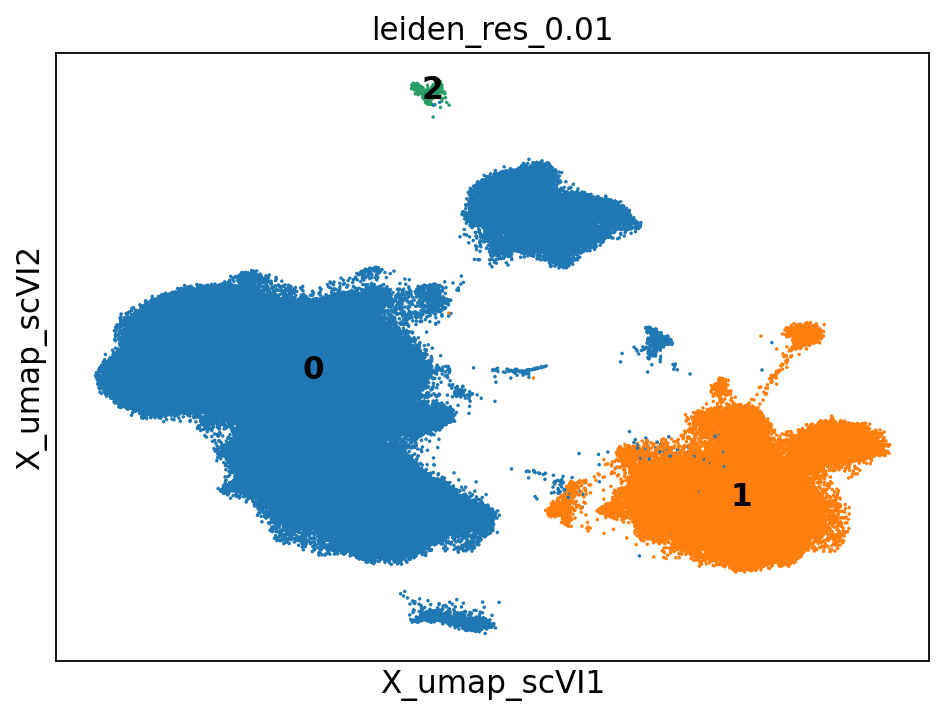

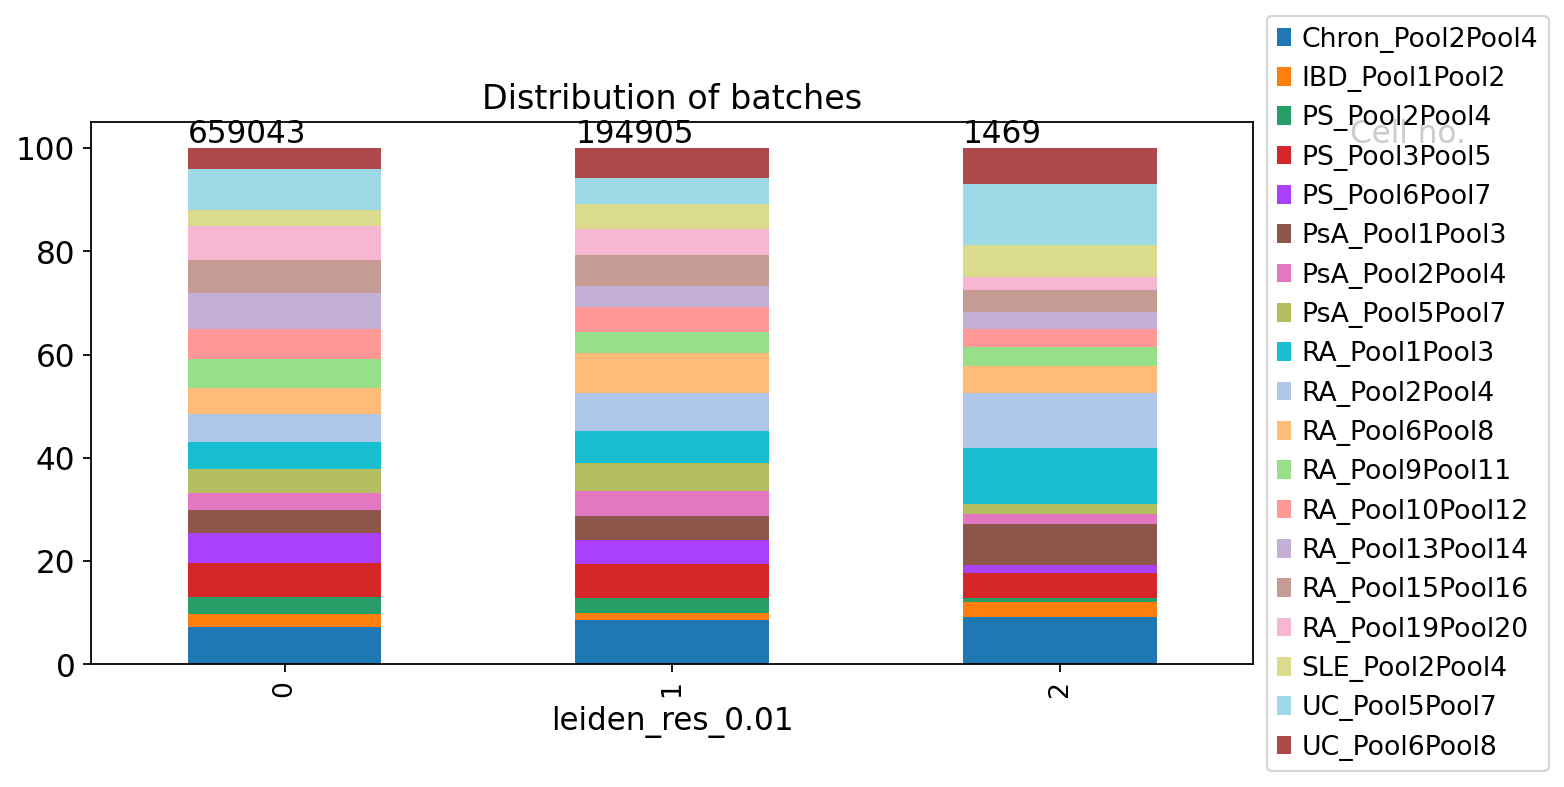

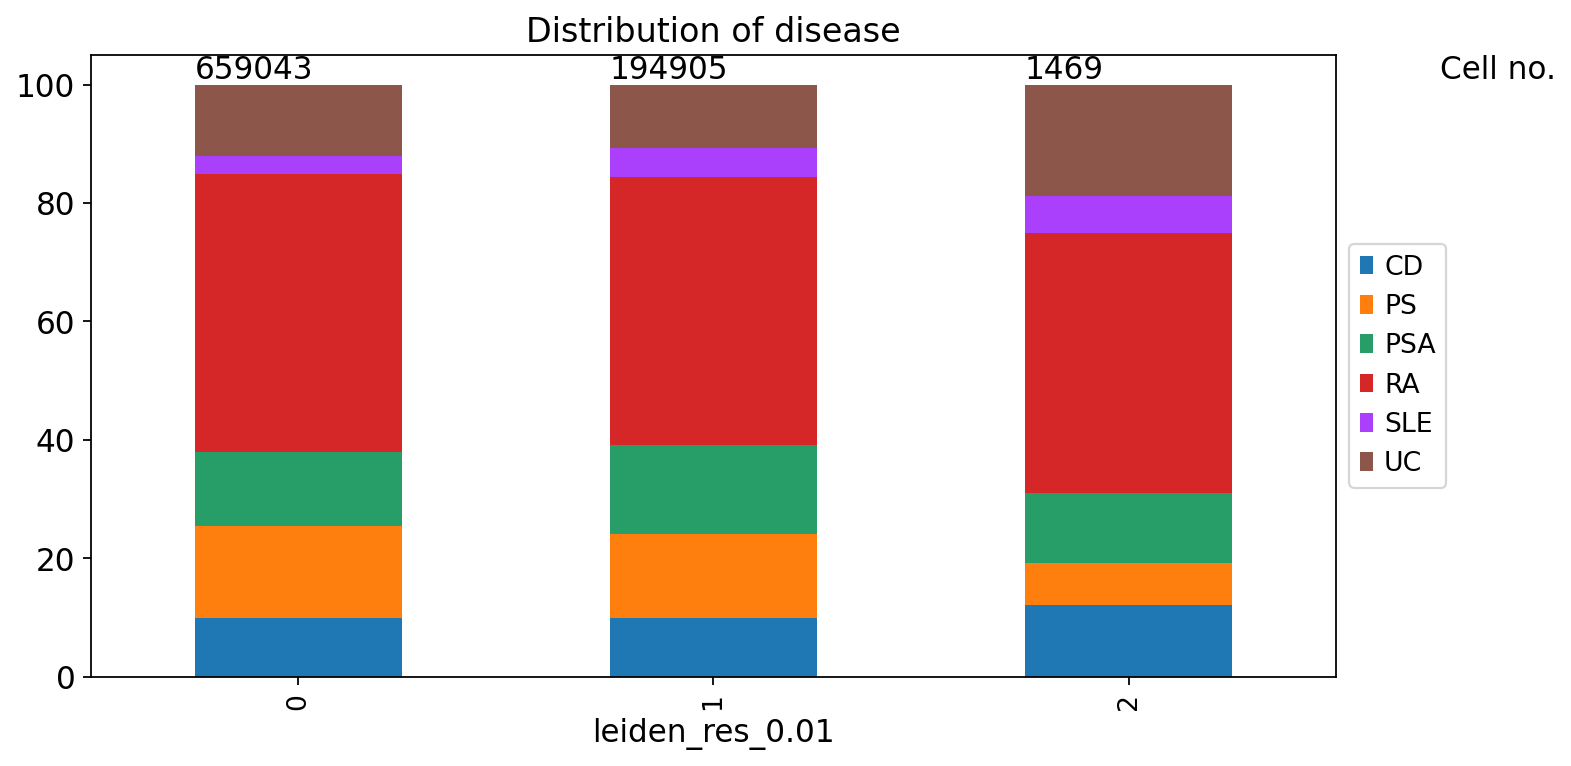

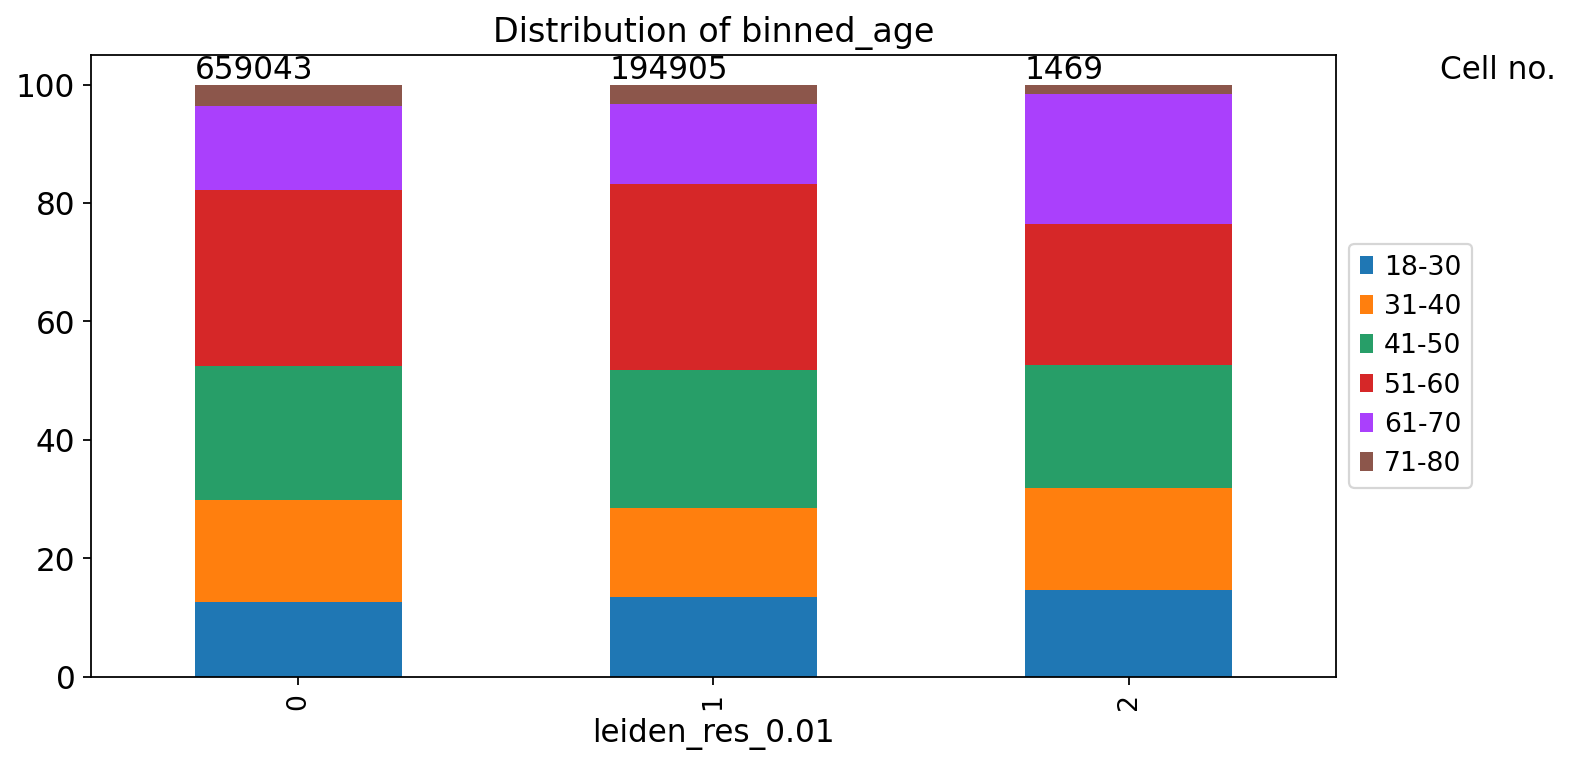

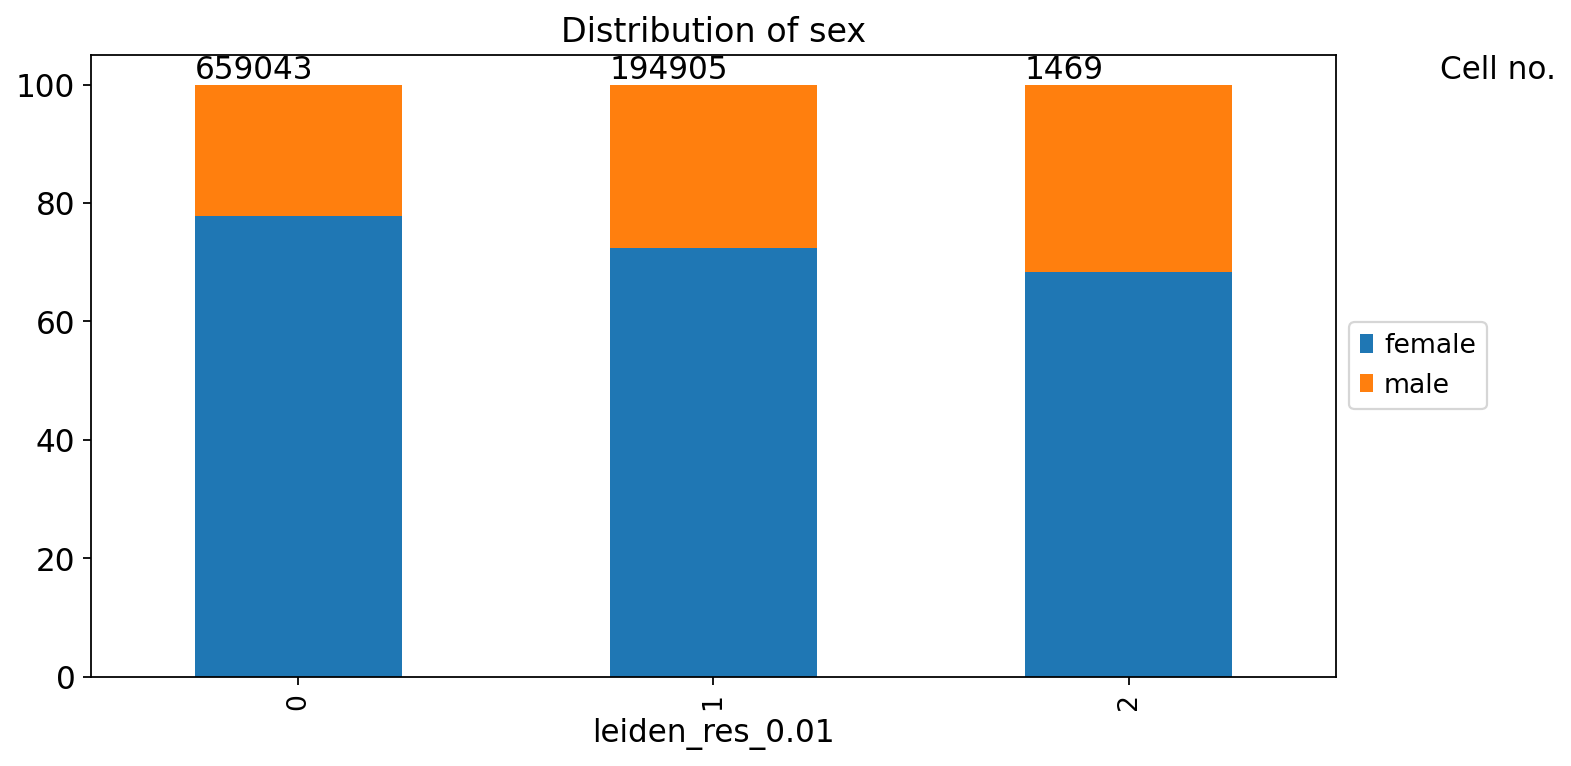

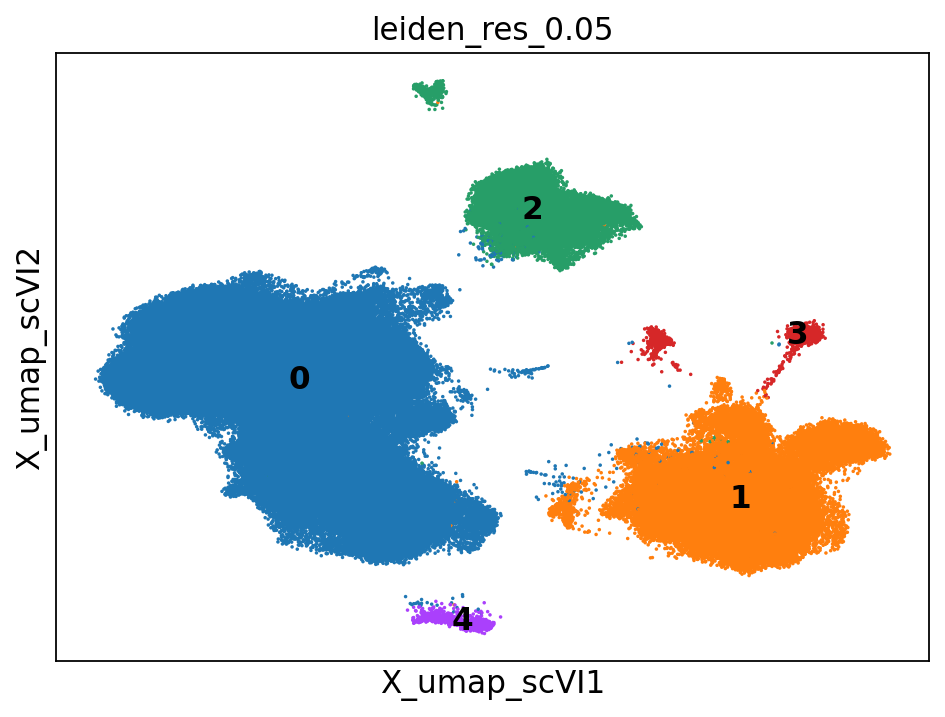

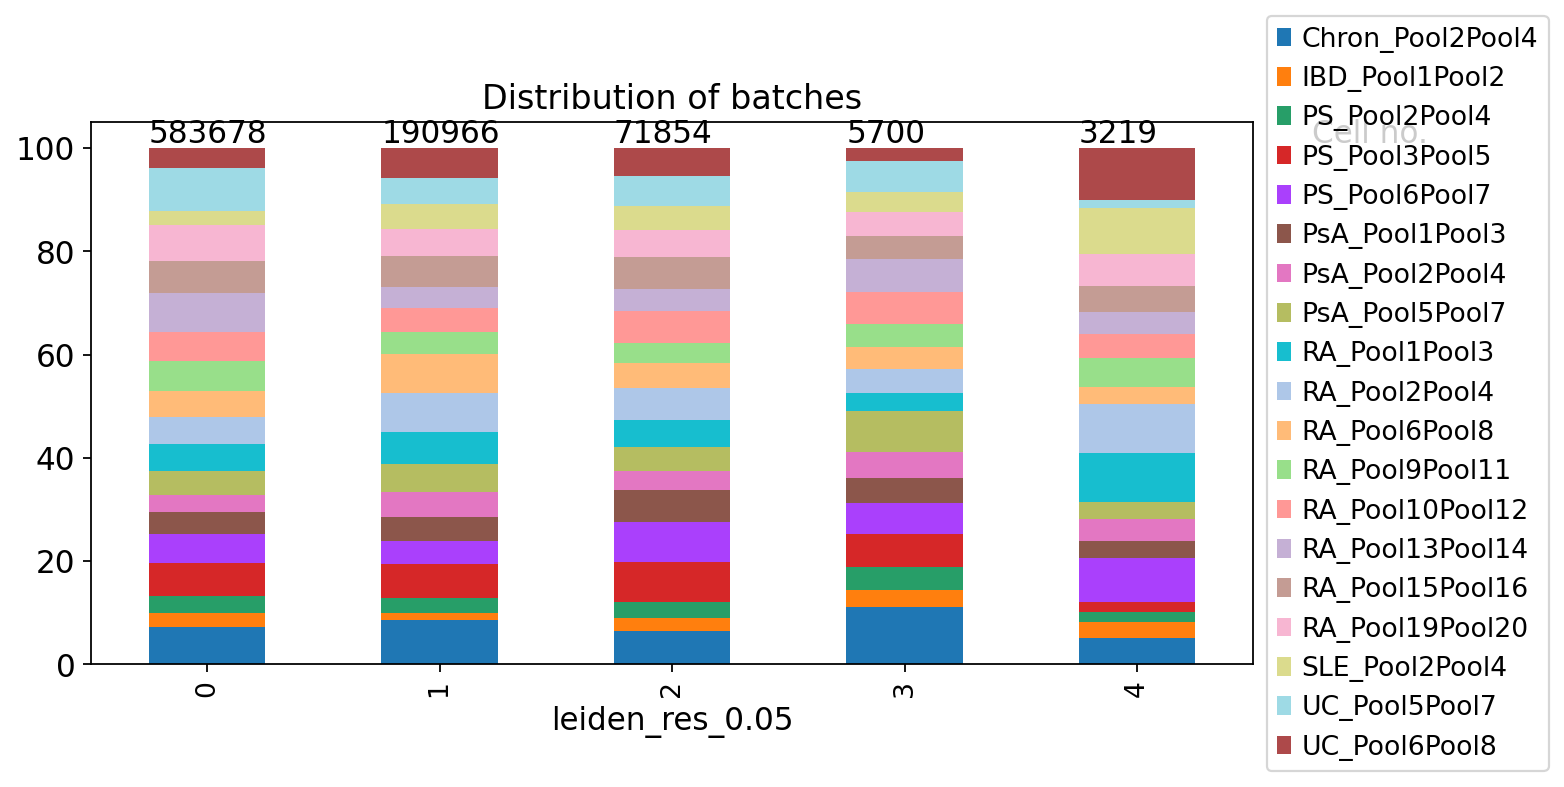

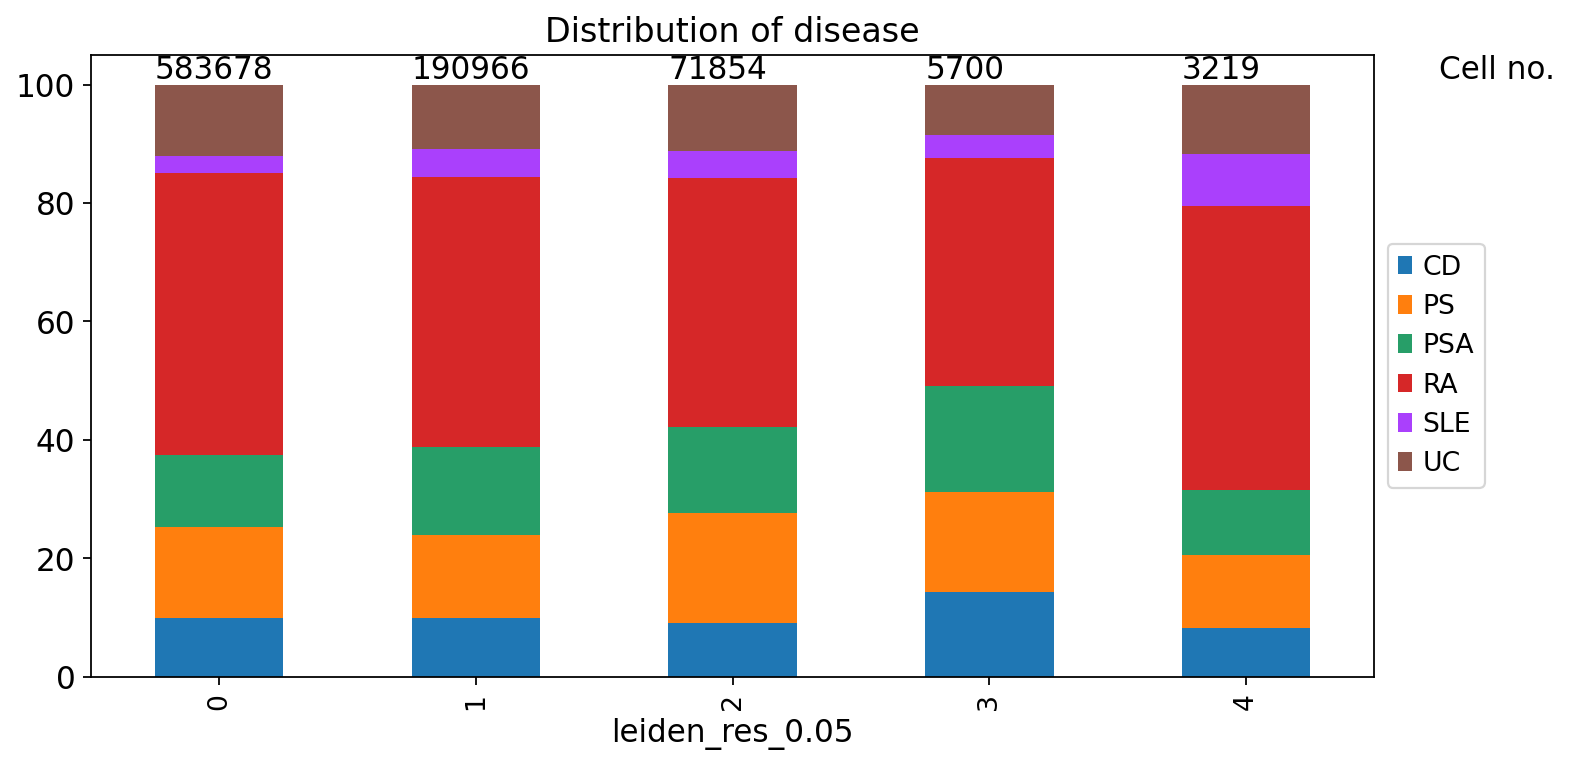

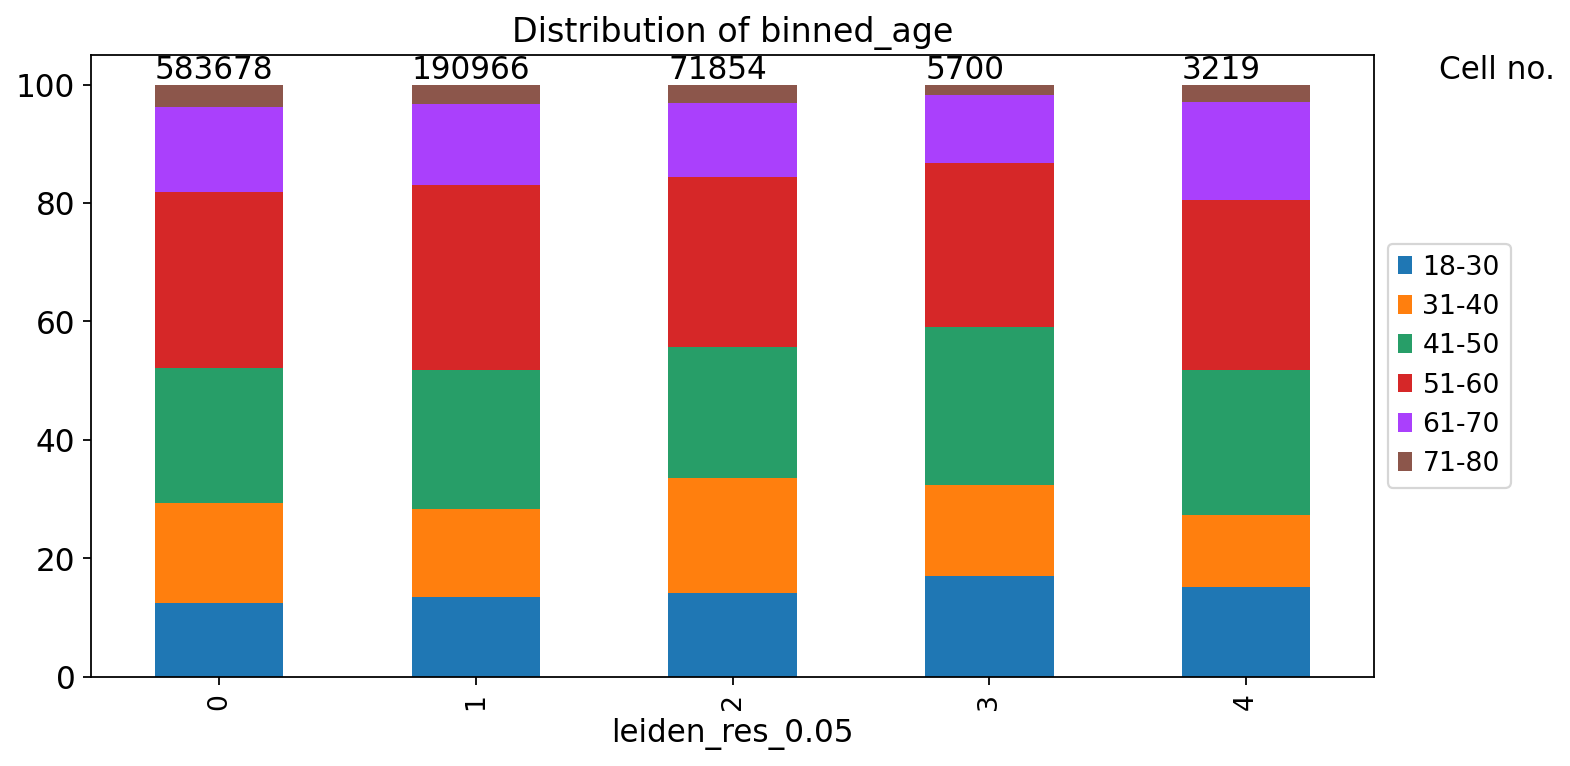

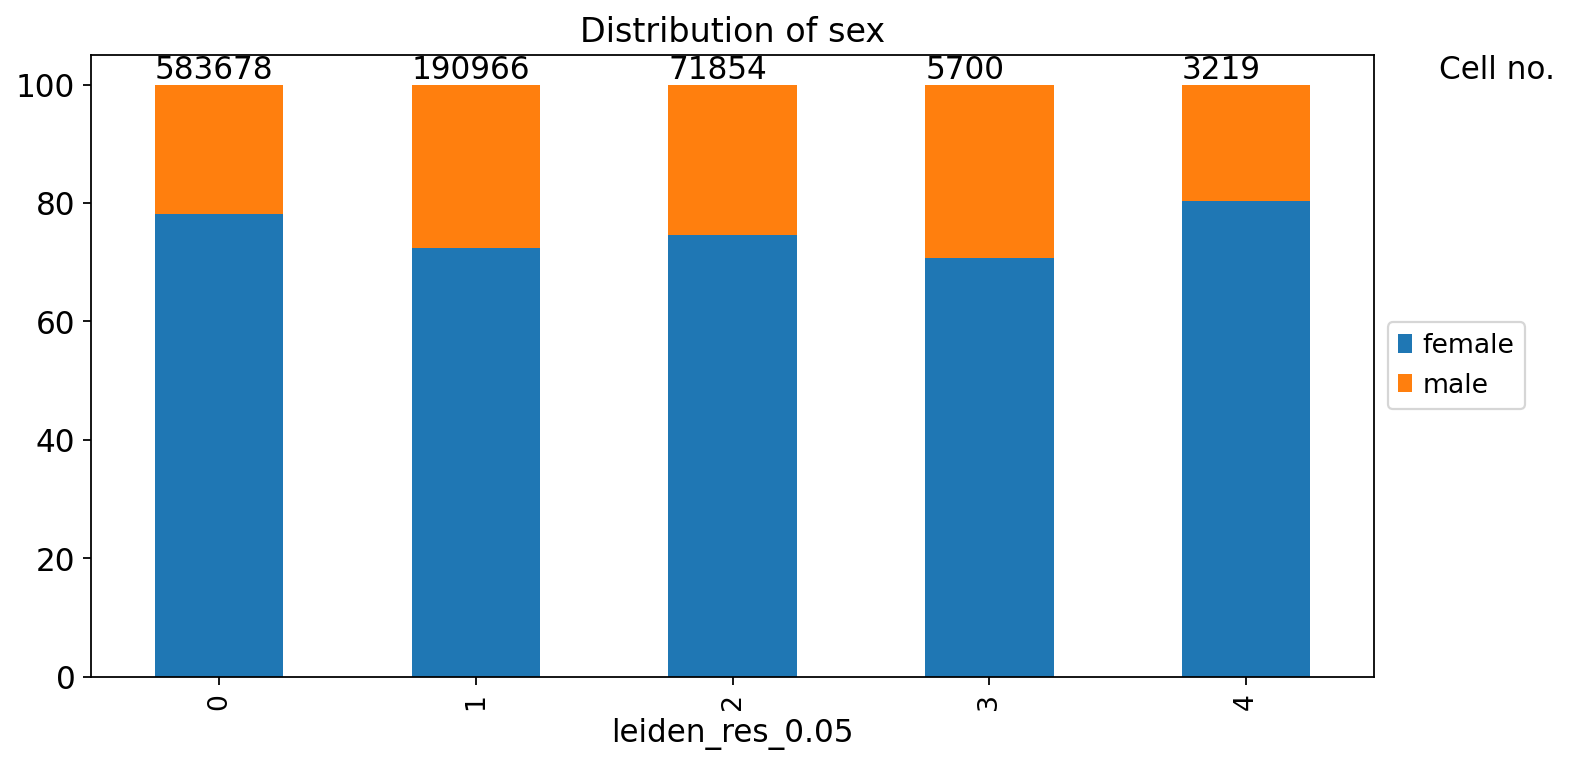

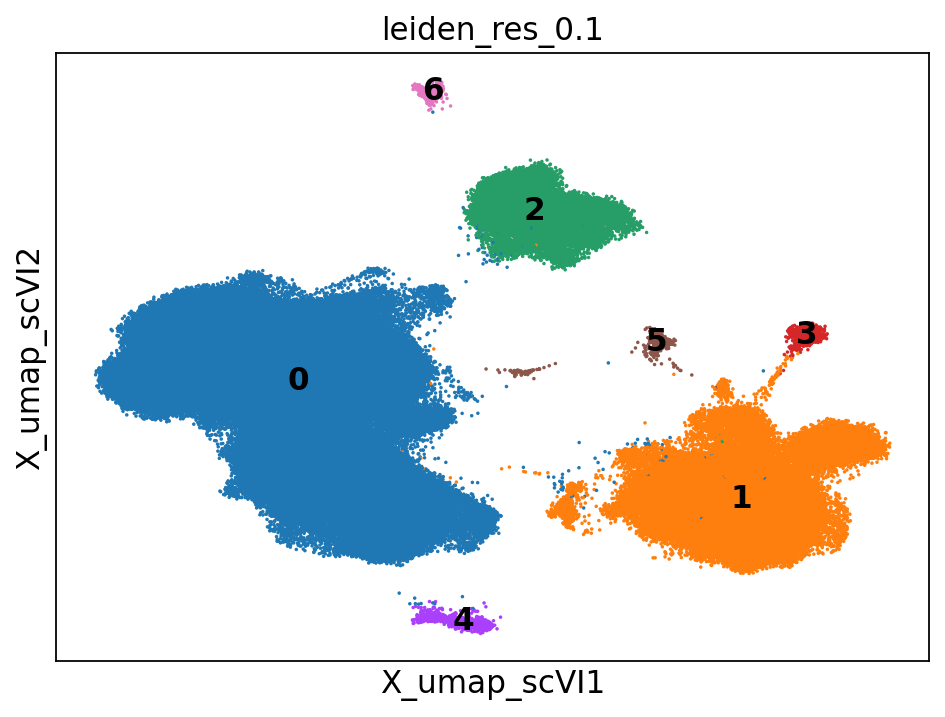

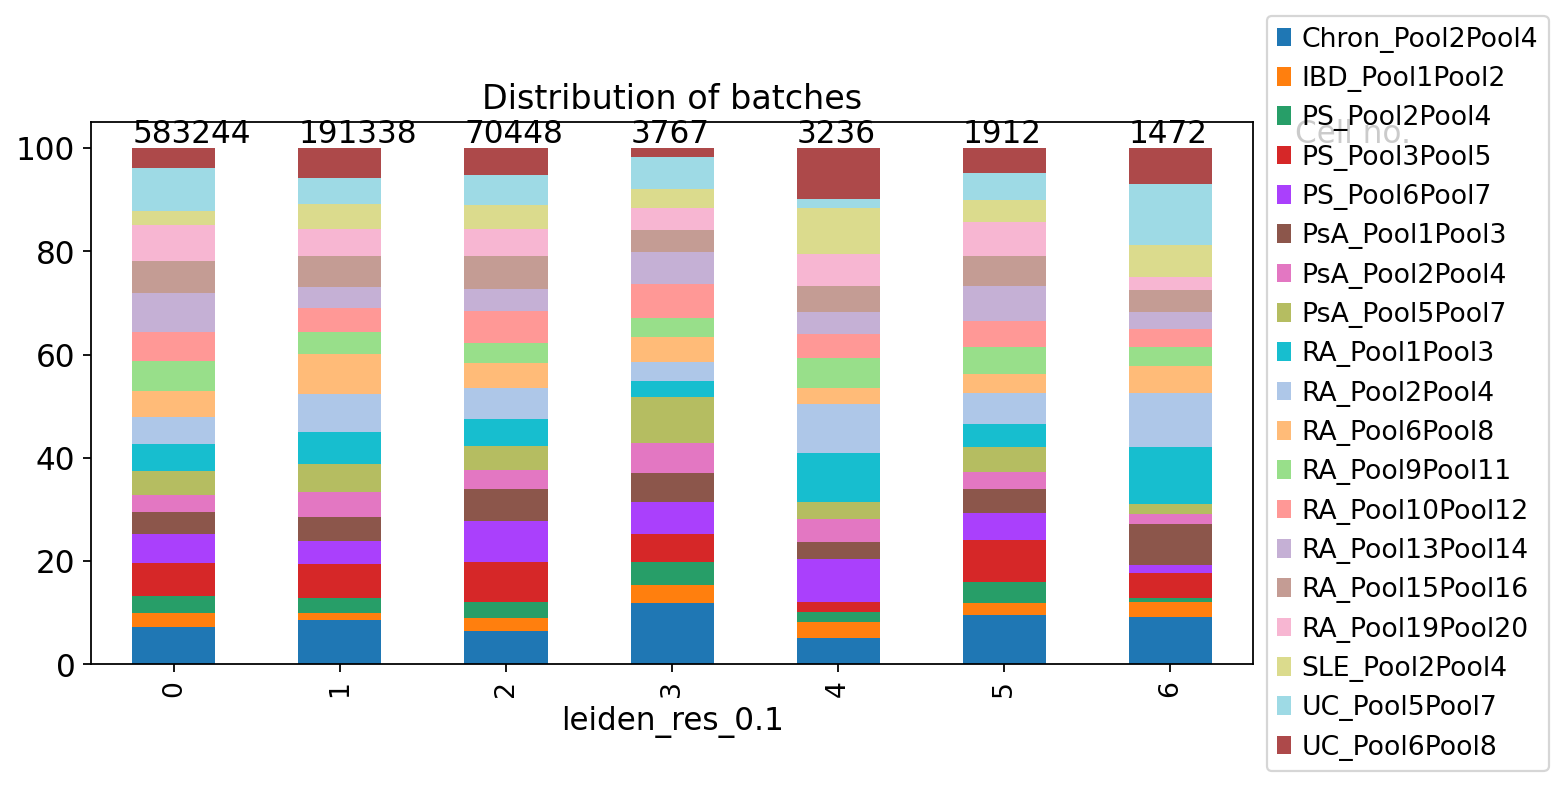

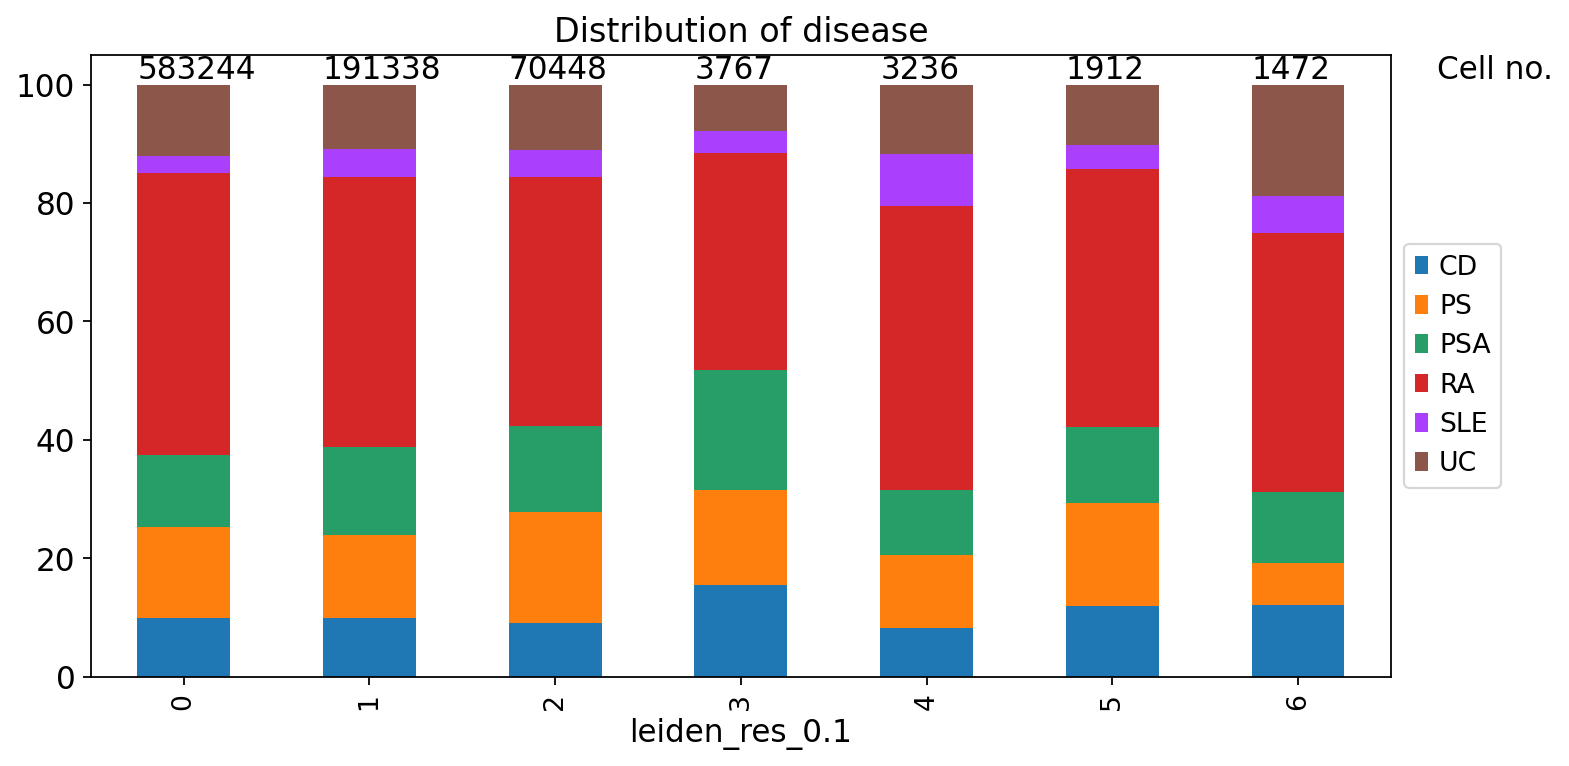

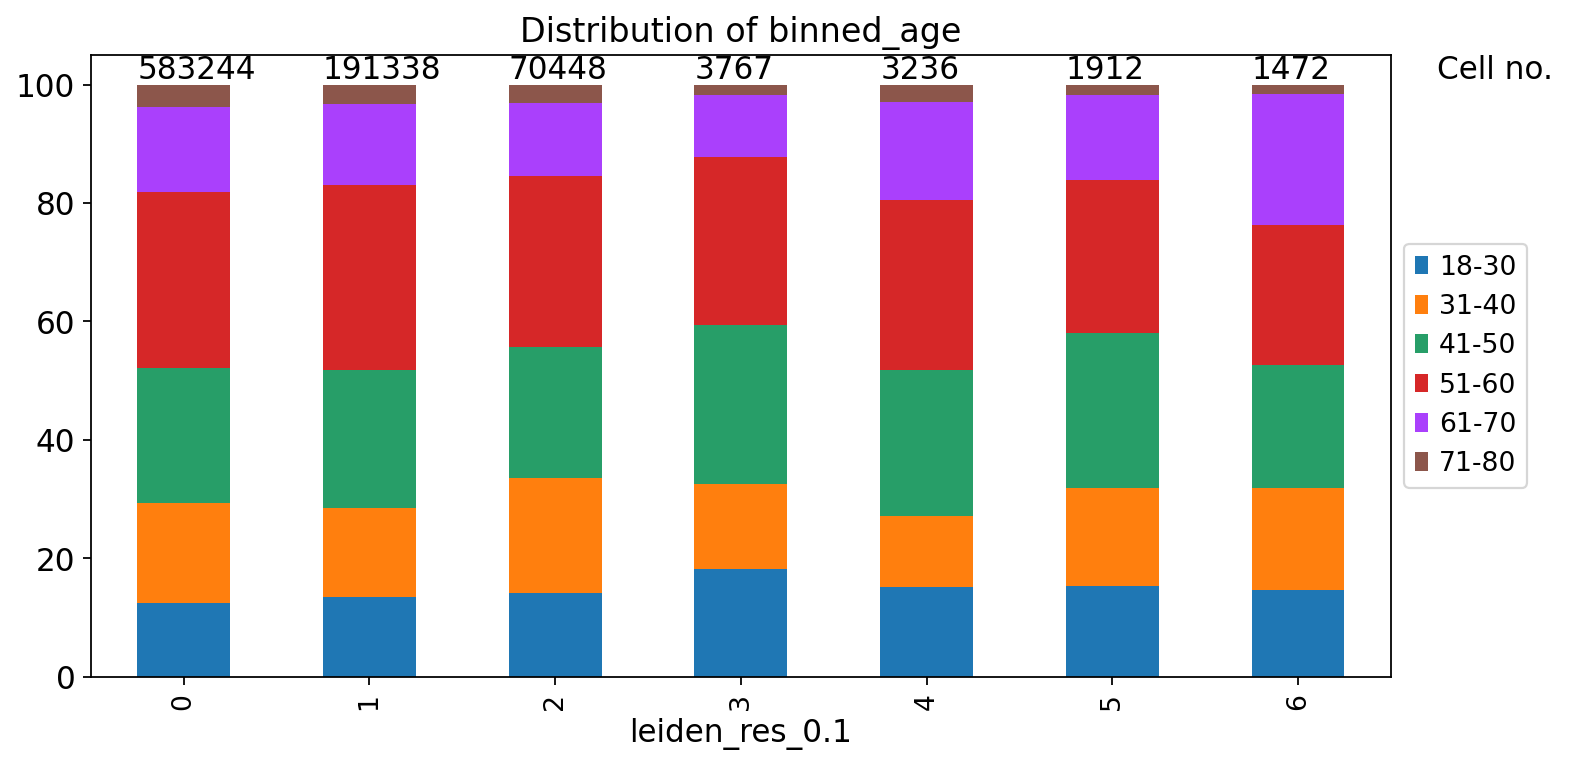

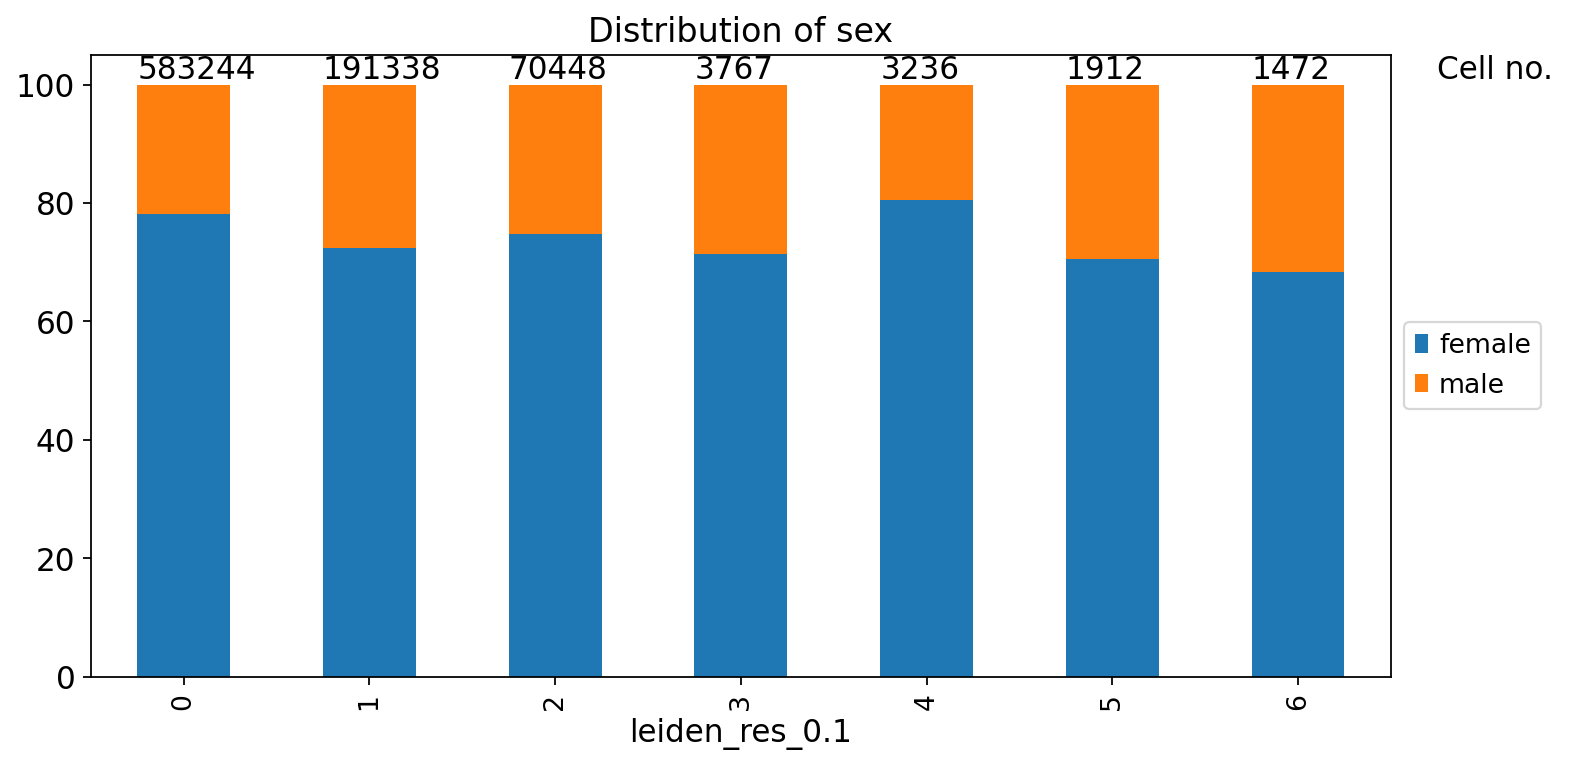

In [11]:
for res in resolutions_to_explore:
    leiden_cluster = "leiden_res_" + str(res)
    
    # Clustering
    sc.tl.leiden(adata, resolution=res, key_added=leiden_cluster, neighbors_key='scVI')

    if overwriteFigures:
        
        # Explore clustering
        # Subsetting and randomizing for optimal plotting
        random_indices = balanced_sample(adata.obs, cols = leiden_cluster, frac = fraction, shuffle = True, random_state = 42).cellID
        
        sc.set_figure_params(figsize=(7, 5))
    
        fig = sc.pl.embedding(adata[random_indices, :], basis="X_umap_scVI", color=leiden_cluster, show=True, return_fig=True, size=10, legend_loc="on data")
        plt.savefig(here('02_cell_annotation/SCGT00_CentralizedDataset/01_fromDataset_to_CellLineages/figures/UMAP_clusters_res{}.pdf'.format(res)), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

        # Evaluate co-variables distribution across clusters
        pdf_pages = PdfPages(here("02_cell_annotation/SCGT00_CentralizedDataset/01_fromDataset_to_CellLineages/figures/Barplots_covariates_across_clusters_{}.pdf".format(res)))
        for variable in list_of_variables:
            sc.set_figure_params(figsize=(10, 5))
            composition_barplot(adata, xattr=leiden_cluster, yattr=variable, title="Distribution of {}".format(variable), save_pdf=pdf_pages)
        pdf_pages.close()

In [12]:
adata

AnnData object with n_obs × n_vars = 855417 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'S_score', 'G2M_score', 'phase', 'leiden_res_0.01', 'leiden_res_0.05', 'leiden_res_0.1'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'high

## Save clustered object

In [13]:
if overwriteData:
    clusterDF = adata.obs[['leiden_res_{}'.format(r) for r in resolutions_to_explore]]
    # Save clustering as DF
    clusterDF.to_pickle(path=here('02_cell_annotation/SCGT00_CentralizedDataset/01_fromDataset_to_CellLineages/results/SCGT00_clustering_resolutions_to_explore.pkl'))

# Known marker genes visualization

In [14]:
marker_genes_lineage_list = [genes for lineage_genes in marker_genes_dict["lineages"].values() for genes in lineage_genes]

## Explore canonical marker genes

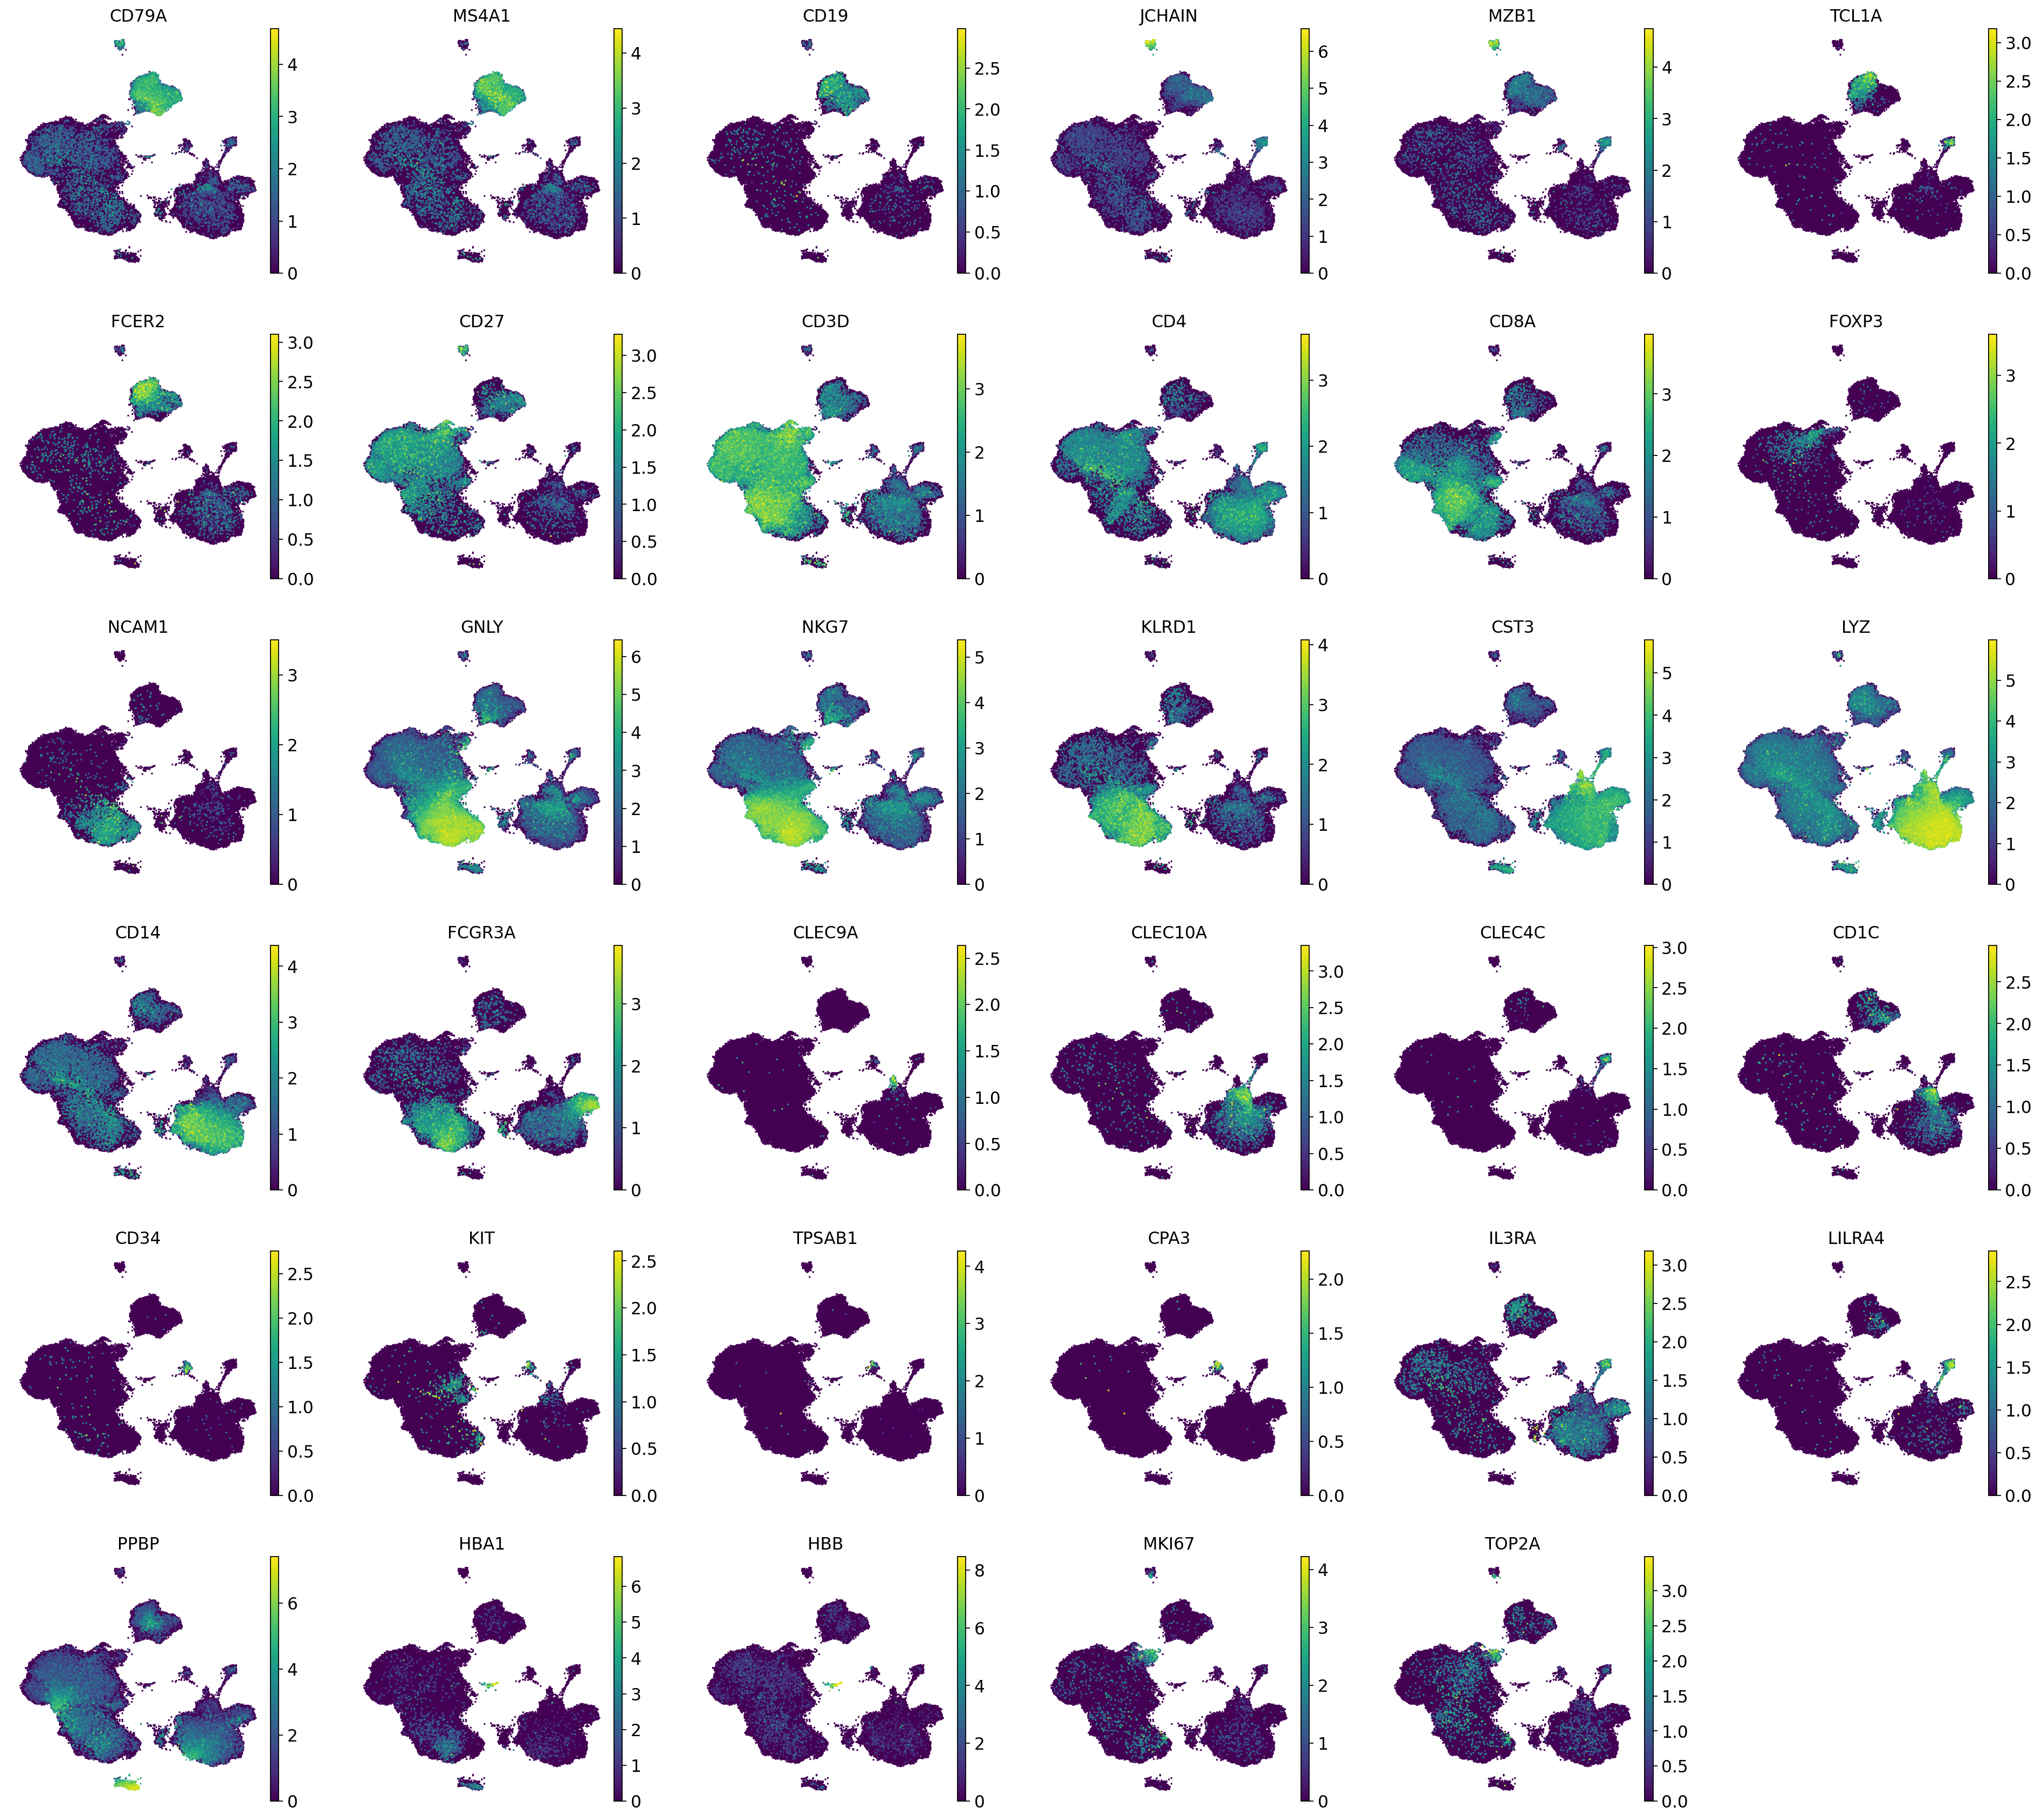

In [15]:
# Subsetting and randomizing for optimal plotting
random_indices = balanced_sample(adata.obs, cols = ["sampleID"], frac = fraction, shuffle = True, random_state = 42).cellID
ID2SymbolDF = generateID2SymbolDF(varDF = adata[random_indices, :].var, symbolList = marker_genes_lineage_list, ID_col = 'index', symbols_col = 'symbol', HUGOstatus_col = 'HUGO_status', behaviour = 'all')

# FeaturePlot
sc.set_figure_params(figsize=(4, 4))
fig = sc.pl.embedding(basis = 'X_umap_scVI', 
                adata = adata[random_indices, :], 
                color=ID2SymbolDF["gene_id"], title= ID2SymbolDF["symbol"], s=10, 
                frameon=False, ncols=6,
                use_raw=False, 
                show=False, return_fig=False)

if overwriteFigures:
    plt.savefig(here('02_cell_annotation/SCGT00_CentralizedDataset/01_fromDataset_to_CellLineages/figures/UMAP_CanonicalMarkers.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

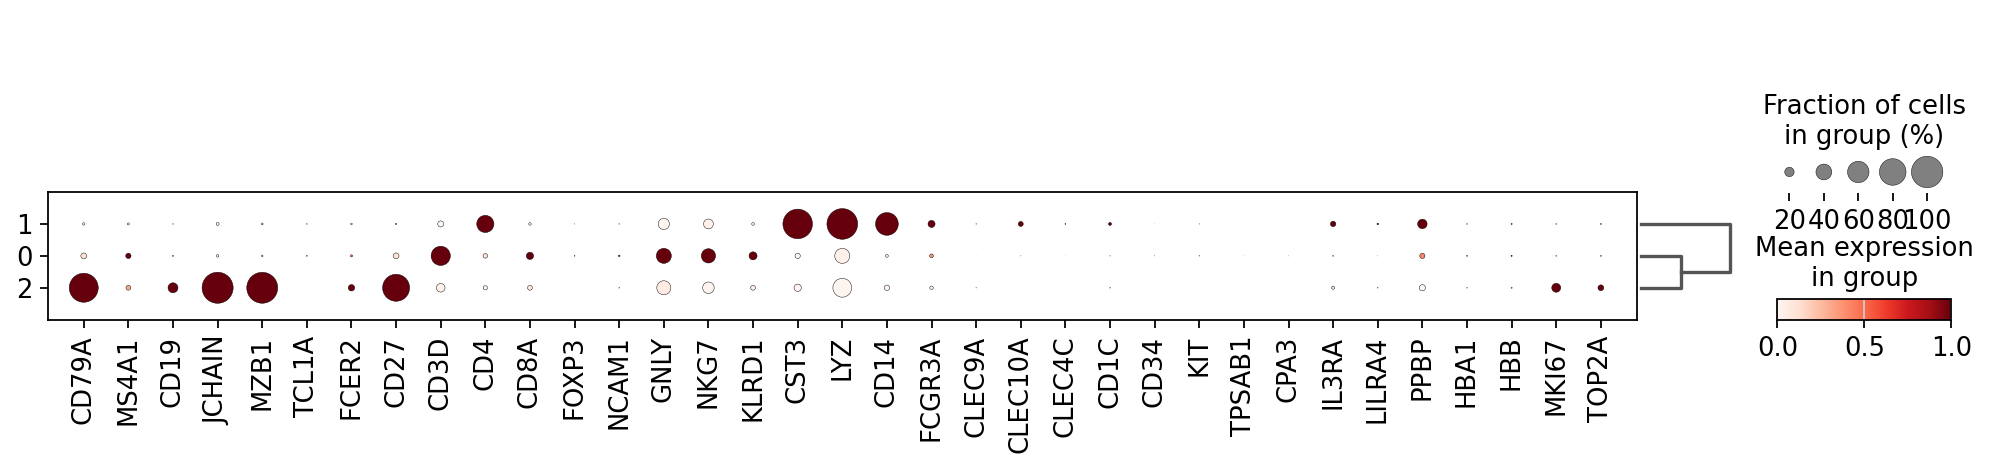

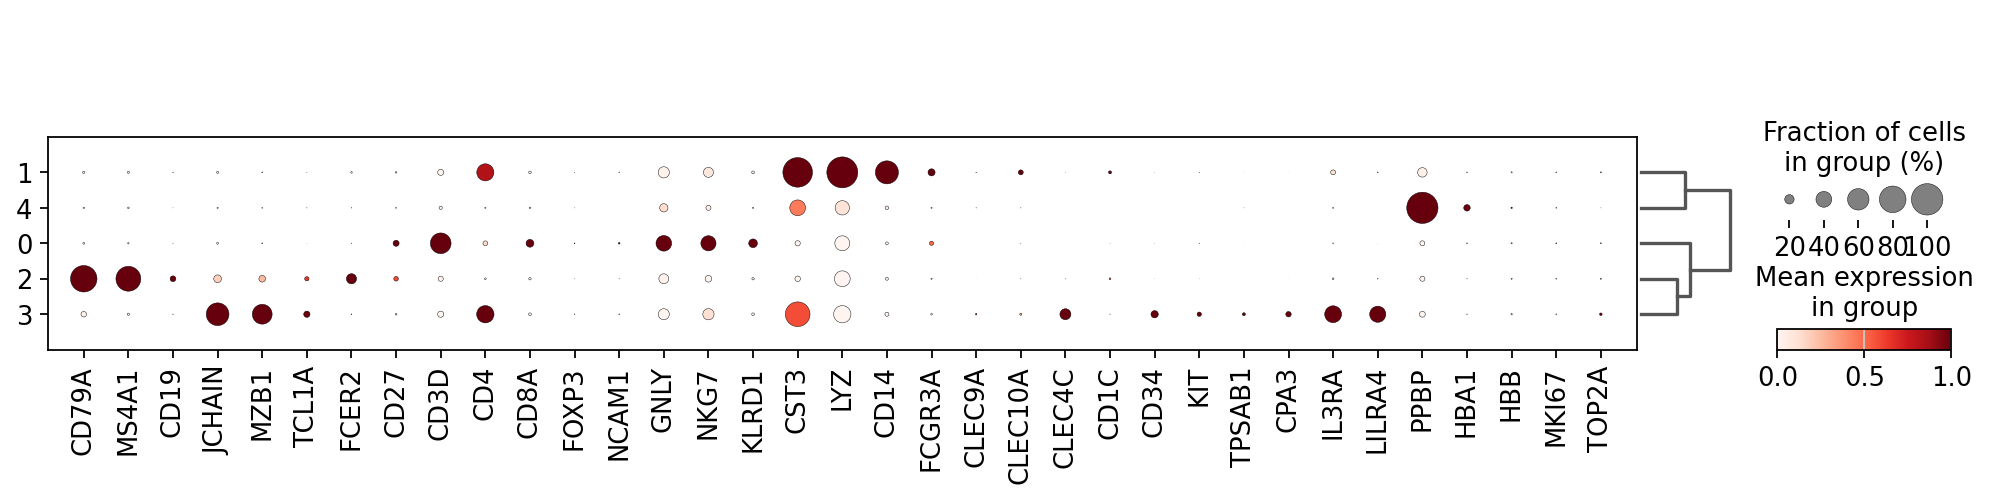

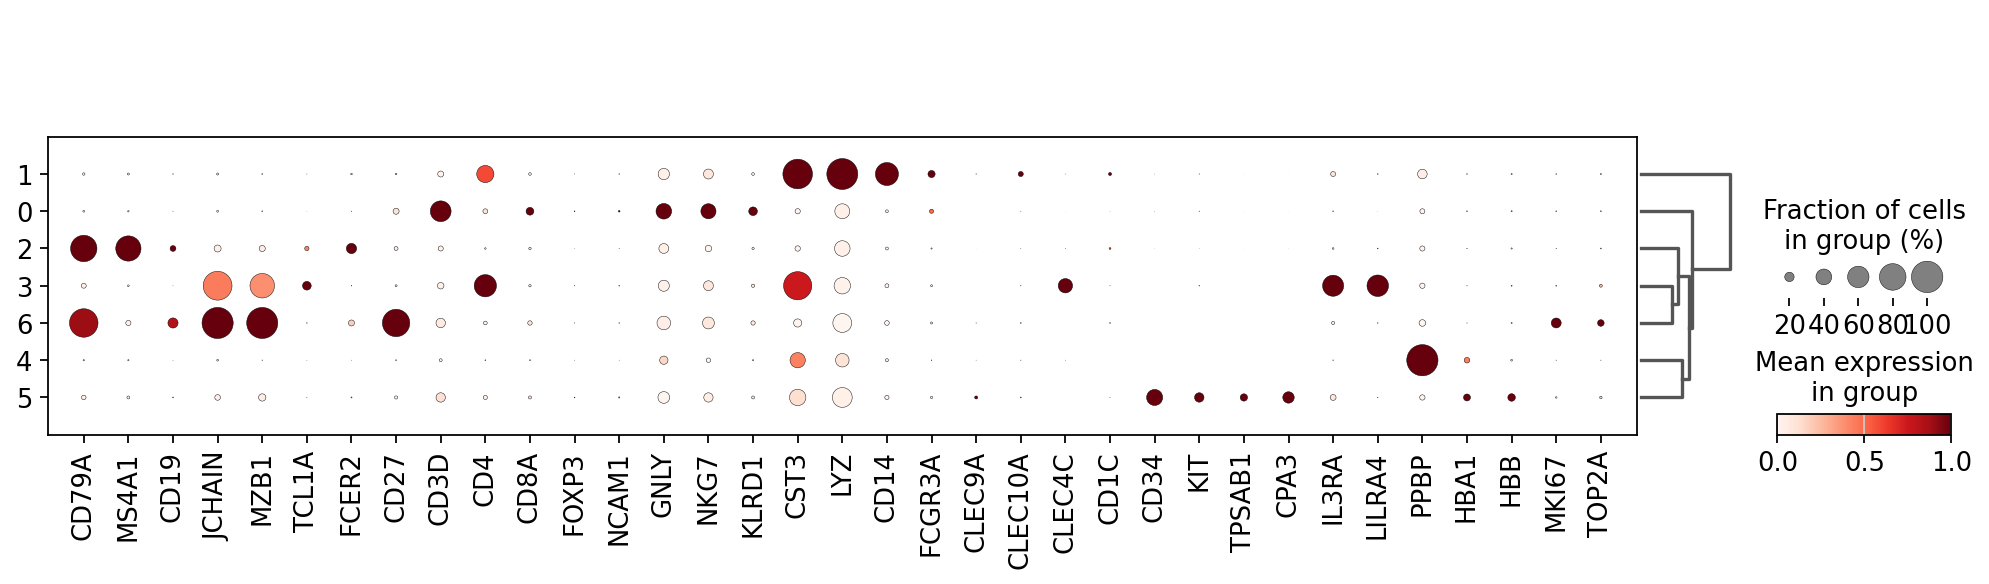

In [16]:
for res in resolutions_to_explore:
    leiden_cluster = "leiden_res_" + str(res)
    
    # Subsetting and randomizing for optimal plotting
    random_indices = balanced_sample(adata.obs, cols = leiden_cluster, frac = fraction, shuffle = True, random_state = 42).cellID
    ID2SymbolDF = generateID2SymbolDF(varDF = adata[random_indices, :].var, symbolList = marker_genes_lineage_list, 
                                      ID_col = 'index', symbols_col = 'symbol', HUGOstatus_col = 'HUGO_status', behaviour = 'all')
    
    # Dotplot
    sc.set_figure_params(figsize=(15, 7))
    fig = sc.pl.dotplot(adata[random_indices, :],
                        var_names = ID2SymbolDF["gene_id"],
                        groupby=leiden_cluster, standard_scale='var', 
                  use_raw = False, dendrogram=True, show=False, return_fig=False)
        # replace ensembls ids by gene symbol in plot
    _ = fig['mainplot_ax'].set_xticklabels(ID2SymbolDF["symbol"])
    
    if overwriteFigures:
        plt.savefig(here('02_cell_annotation/SCGT00_CentralizedDataset/01_fromDataset_to_CellLineages/figures/Dotplot_CanonicalMarkers_res{}.pdf'.format(res)), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

In [17]:
session_info.show()